In [22]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model
from keras import models, layers

In [2]:
Image_size = 360
Batch_size = 32
Channels=3
Epochs=30

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "combined",
    shuffle=True,
    image_size = (Image_size,Image_size),
    batch_size = Batch_size
)

Found 700 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['cancer', 'non_cancer']

In [5]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 360, 360, 3)
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


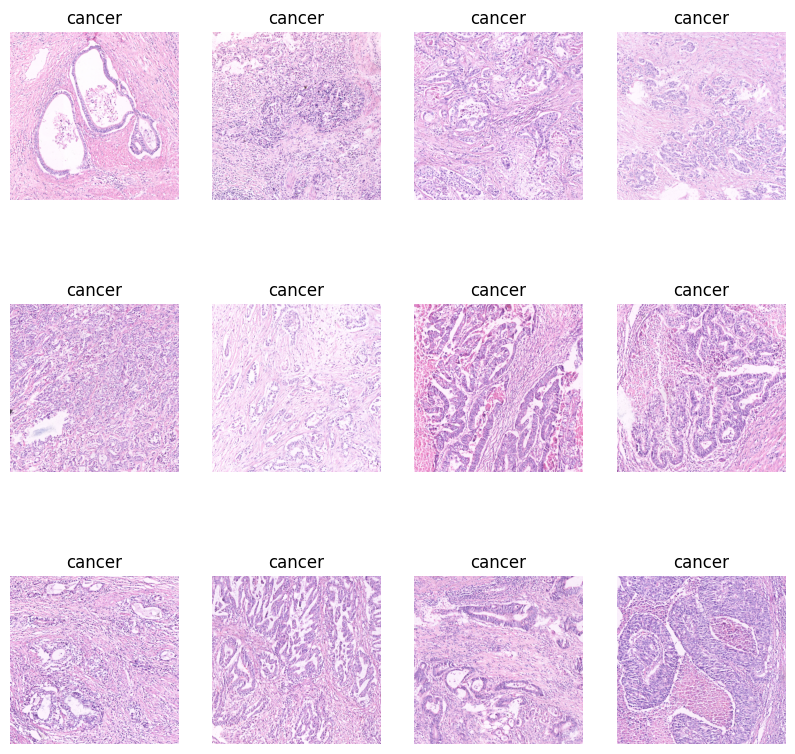

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def dataset_partition(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    dataset_size=len(dataset)

    if shuffle:
        dataset=dataset.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*dataset_size)
    val_size=int(val_split*dataset_size)
    Train_dataset= dataset.take(train_size)
    Val_dataset=dataset.skip(train_size).take(val_size)
    Test_dataset=dataset.skip(train_size).skip(val_size)
    return Train_dataset,Val_dataset,Test_dataset

In [8]:
Train_dataset,Val_dataset,Test_dataset=dataset_partition(dataset,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000)

In [9]:
len(Train_dataset)

17

In [10]:
len(Val_dataset)

2

In [11]:
len(Test_dataset)

3

In [12]:
Train_dataset=Train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_dataset=Val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Test_dataset=Test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_size,Image_size),
    layers.Rescaling(1.0 / 255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [15]:
# input_shape=(Batch_size,Image_size,Image_size,Channels)
# model= models.Sequential([
#     resize_and_rescale,
#     data_augmentation,

#     layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(128,(3,3),activation='relu'),
#     layers.MaxPooling2D((2,2)),
    
#     layers.Flatten(),
#     layers.Dense(64,activation='relu'),
#     layers.Dense(32,activation='relu'),
#     layers.Dense(3,activation='softmax')
# ])

# model.build(input_shape=input_shape)

In [16]:
pretrained_model=tf.keras.applications.ResNet50(include_top=False,input_shape=(360,360,3),pooling='avg',classes=2,weights='imagenet')
for layers in pretrained_model.layers:
    layers.trainanble=False




In [17]:
pretrained_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 366, 366,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 180, 180,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 180, 180,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 180, 180,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 182, 182,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 90, 90,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 90, 90,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 90, 90,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 90, 90,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 90, 90,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 90, 90,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 90, 90,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 90, 90,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 90, 90,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 90, 90,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 90, 90,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [40]:


# Assuming your 2D data has shape (num_samples, num_features)
# Reshape it to 4D with shape (num_samples, height, width, num_channels)
# Here, I'm assuming each sample represents an image with shape (360, 360, 3)
num_samples = dataset.shape[0]
height = 360
width = 360
num_channels = 3
reshaped_data = np.reshape(your_2D_data, (num_samples, height, width, num_channels))

# Now you can use this reshaped data as input to your model


AttributeError: '_PrefetchDataset' object has no attribute 'shape'

In [38]:


model = models.Sequential()
model.add(pretrained_model)
# model.add(layers.Reshape((1, 1, -1)))
# model.add(layers.Conv2D(2048, (1, 1)))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2,activation='softmax'))

model.build(input_shape=(None,360, 360, 3))



ValueError: Input 0 of layer "global_average_pooling2d_7" is incompatible with the layer: expected ndim=4, found ndim=2. Full shape received: (None, 2048)

In [39]:
# model.compile(
#     optimizer='adam',
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#     metrics=['accuracy']
# )


In [33]:
#vgg16
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [34]:
#vgg16
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 1, 1, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 1, 1, 2048)     │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 0)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,915,200 (106.49 MB)

 Trainable params: 27,862,080 (106.29 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [35]:
history = model.fit(
    Train_dataset,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=Val_dataset
)

Epoch 1/30


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 0)

In [43]:
scores= model.evaluate(Test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 892ms/step - accuracy: 0.9141 - loss: 0.2652


In [44]:
scores

[0.25511670112609863, 0.90625]

In [45]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training loss and Validation loss Accuracy')

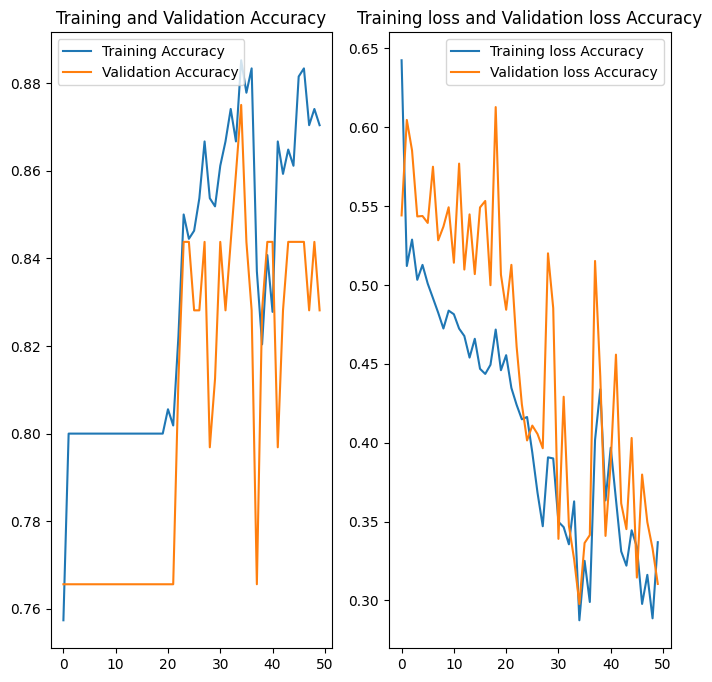

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc,label='Training Accuracy')
plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(Epochs),loss,label='Training loss Accuracy')
plt.plot(range(Epochs),val_loss,label='Validation loss Accuracy')
plt.legend(loc='upper right')
plt.title('Training loss and Validation loss Accuracy')

first image to Predict
actual label: cancer
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
[8.8887215e-01 1.1112782e-01 3.5204397e-09]
predicted label  cancer


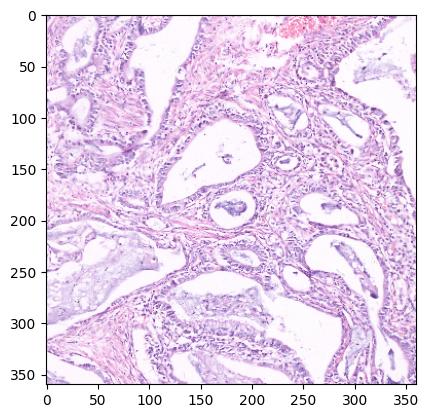

In [47]:
for image_batch,labels_batch in Test_dataset.take(1):
    first_image= image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()

    print("first image to Predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print(batch_prediction[0])
    print("predicted label ",class_names[np.argmax(batch_prediction[0])])


In [48]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])), 2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


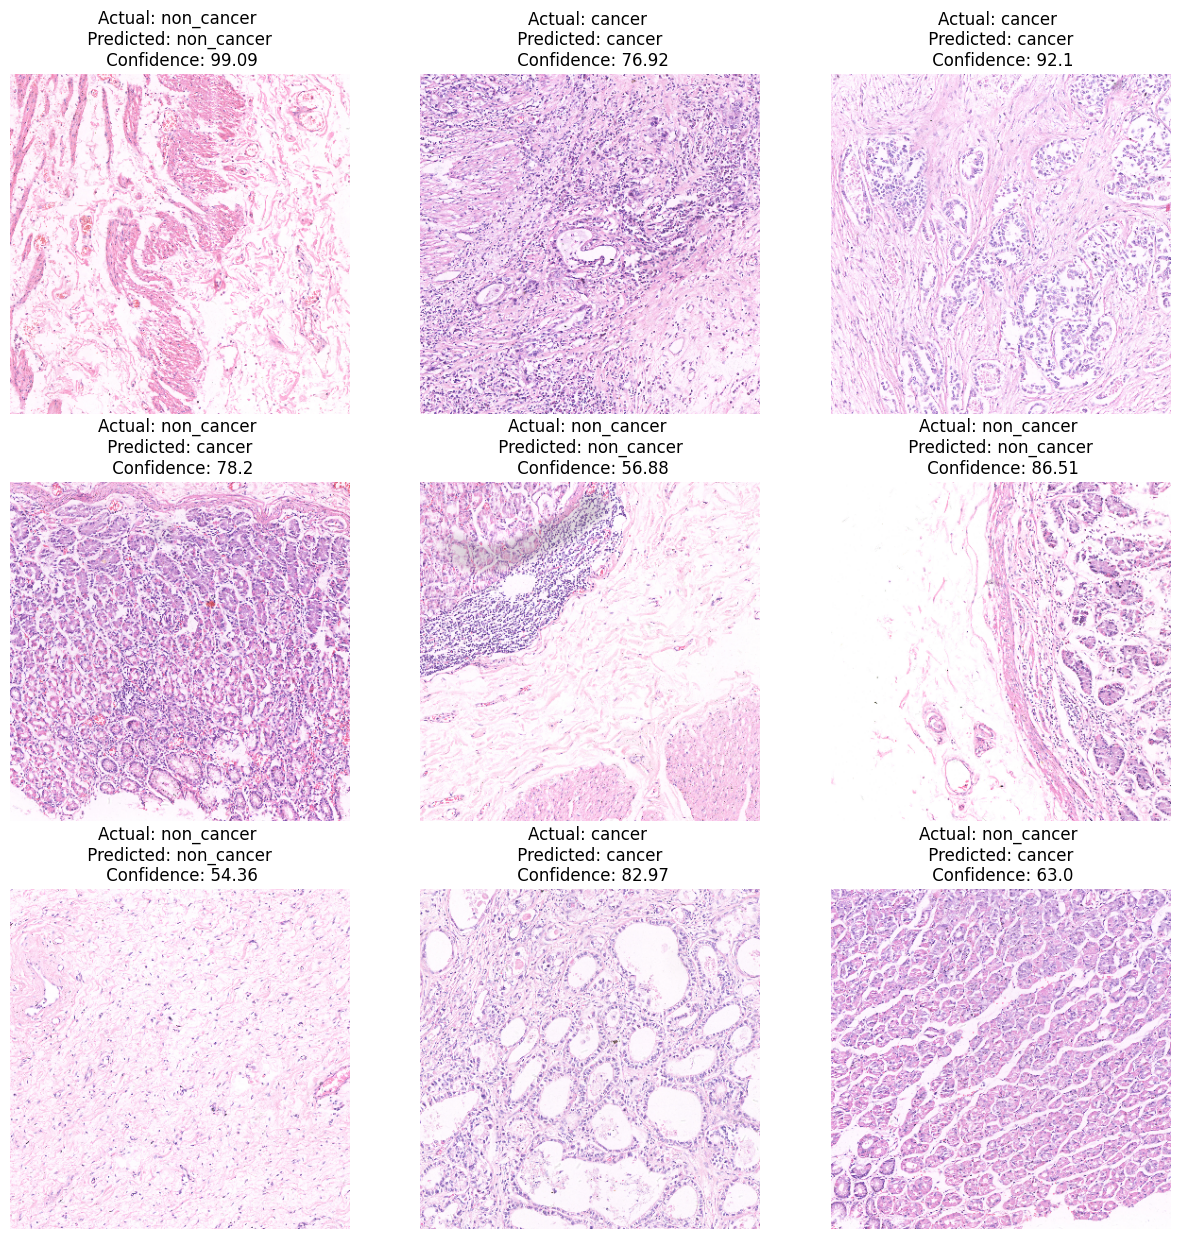

In [53]:
plt.figure(figsize=(15,15))
for images,labels in Test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]

        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}")

        plt.axis("off")

In [70]:
import os
import tensorflow as tf
from tensorflow.keras.models import model_from_json

# Directory where you want to save the model
save_directory = r"model"

# Create the directory if it doesn't exist
os.makedirs(save_directory, exist_ok=True)

# Assuming you have a trained model named 'model'

# Save model architecture as JSON
model_json = model.to_json()
with open(os.path.join(save_directory, "model.json"), "w") as json_file:
    json_file.write(model_json)

# Save model weights
model.save_weights(os.path.join(save_directory, "model_weights.weights.h5"))

# Load model architecture from JSON
with open(os.path.join(save_directory, 'model.json'), 'r') as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)




In [51]:
def save_history(History):
    acc = pd.Series(History.history['accuracy'], name='accuracy')
    loss = pd.Series(History.history['loss'], name='loss')
    val_acc = pd.Series(History.history['val_accuracy'], name='val_accuracy')
    val_loss = pd.Series(History.history['val_loss'], name='val_loss')
    com = pd.concat([acc, loss, val_acc, val_loss], axis=1)
    # Be sure to update the storage location!!
    com.to_csv('D:\\meracode\\model\\history.csv')


In [52]:
save_history(history)

In [63]:
def plot_history(history):
    plt.figure(figsize=(14, 6))
    plt.subplot(1,2,1)
    plt.plot(range(Epochs),acc,label='Training Accuracy')
    plt.plot(range(Epochs),val_acc,label='Validation Accuracy')
    plt.legend(loc='upper left')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1,2,2)
    plt.plot(range(Epochs),loss,label='Training loss Accuracy')
    plt.plot(range(Epochs),val_loss,label='Validation loss Accuracy')
    plt.legend(loc='upper right')
    plt.title('Training loss and Validation loss Accuracy') 

    plt.tight_layout()
    plt.show()

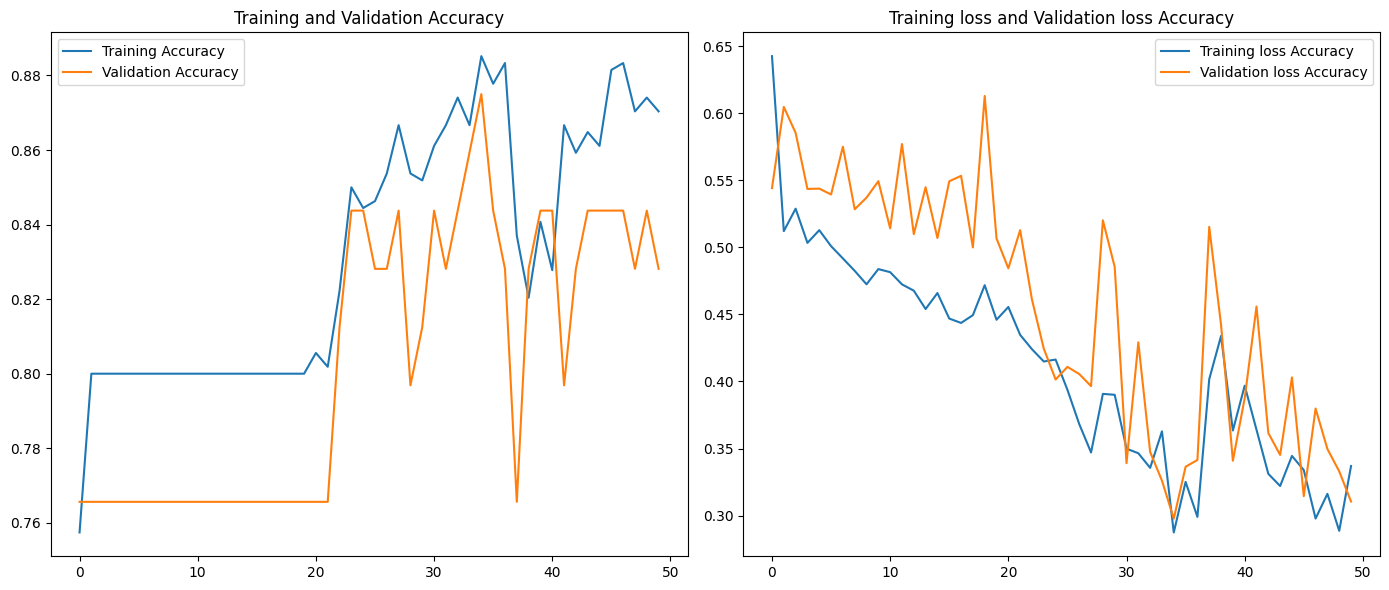

In [64]:
plot_history(history)


In [59]:

def moving_average(data, window_size):
    # Create a kernel for the moving average
    kernel = np.ones(window_size) / window_size
    # Apply the moving average filter
    smoothed_data = np.convolve(data, kernel, mode='same')
    return smoothed_data

def plot_history_smoothed(history, window_size=3):
    Epochs = len(history.history['accuracy'])
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, Epochs + 1), moving_average(history.history['accuracy'], window_size), label='Training Accuracy', marker='o')
    plt.plot(range(1, Epochs + 1), moving_average(history.history['val_accuracy'], window_size), label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Smoothed)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, Epochs + 1), moving_average(history.history['loss'], window_size), label='Training Loss', marker='o')
    plt.plot(range(1, Epochs + 1), moving_average(history.history['val_loss'], window_size), label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (Smoothed)')
    plt.legend()

    plt.tight_layout()
    plt.show()


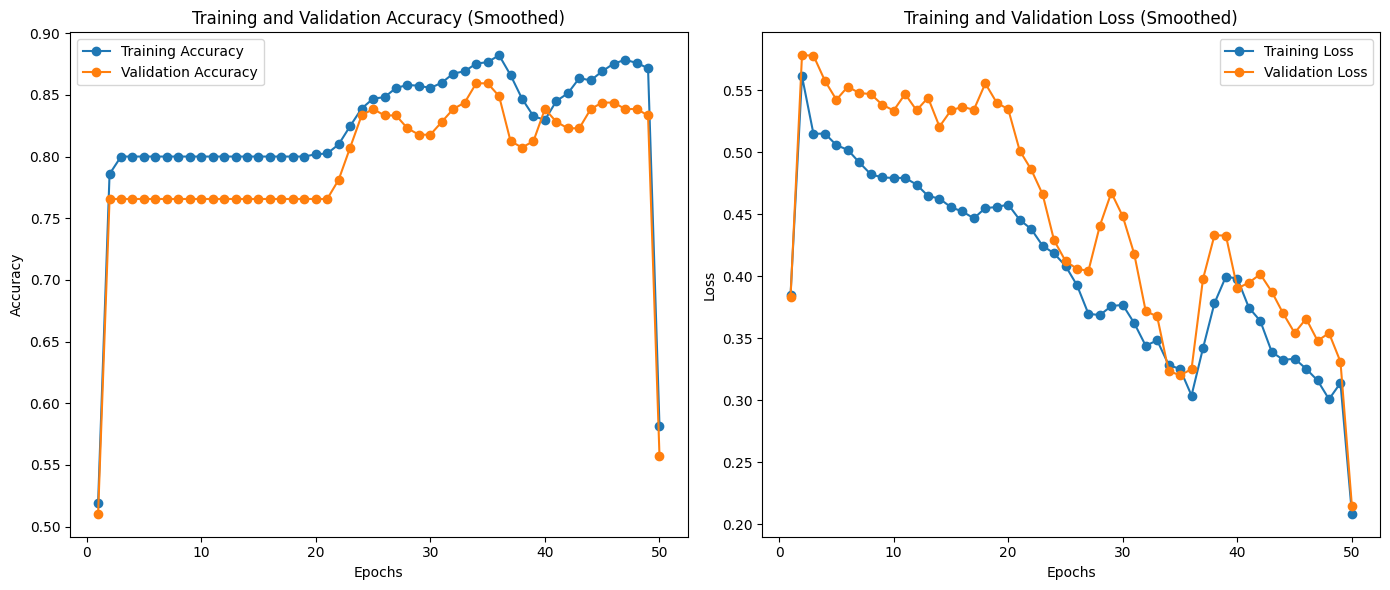

In [60]:
plot_history(history, window_size=3)